In [130]:
import sys
import time
import os
from os.path import join 

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "-1" to run on CPU

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

## Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## TensorFlow
import tensorflow as tf
from tensorflow.python.client import device_lib

## Visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

## text processing
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')

print("Python Current Version:-", sys.version)
print("TensorFlow Version:-    ", tf.__version__)
print("TF-Keras Version:-      ", tf.keras.__version__)

Python Current Version:- 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
TensorFlow Version:-     1.5.0
TF-Keras Version:-       2.1.2-tf


# GPU settings

In [3]:
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())
print("GPU available: ", tf.test.gpu_device_name())

True
True
GPU available:  /device:GPU:0


# Download the datset from here:
https://www.kaggle.com/competitions/feedback-prize-effectiveness/data

In [4]:
TRAIN_ESSAYS_PATH = "../Feedback Prize - Predicting Effective Arguments/train"
TEST_ESSAYS_PATH  = "../Feedback Prize - Predicting Effective Arguments/test"

train = pd.read_csv('../Feedback Prize - Predicting Effective Arguments/train.csv')
test  = pd.read_csv('../Feedback Prize - Predicting Effective Arguments/test.csv')

print(train.shape)
print(test.shape)
train.head()

(36765, 5)
(10, 4)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [128]:
# Get full path of .txt file as a column
train['essay_id_path'] = train['essay_id'].apply(lambda x: f'../feedback-prize-effectiveness/train/{x}.txt')
test['essay_id_path']  = test['essay_id'].apply(lambda x: f'../feedback-prize-effectiveness/test/{x}.txt')

print(train.shape)
print(test.shape)
train.head()

(36765, 6)
(10, 5)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_id_path
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,C:/Users/JK/Downloads/feedback-prize-effective...
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,C:/Users/JK/Downloads/feedback-prize-effective...
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,C:/Users/JK/Downloads/feedback-prize-effective...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,C:/Users/JK/Downloads/feedback-prize-effective...
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,C:/Users/JK/Downloads/feedback-prize-effective...


In [129]:
# How many essays contain the trainset ?
len(train.essay_id.unique())

4191

In [5]:
def get_essay(essay_id, train=True):
    if train:
        PATH = TRAIN_ESSAYS_PATH
    else:
        PATH = TEST_ESSAYS_PATH
    essay_path = join(PATH, f"{essay_id}.txt")
    essay_text = open(essay_path, 'r').read()
    return essay_text

In [6]:
train.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,48636632cad4,4CA37D113612,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


* There are only `4191` unique **essays** and `36691` unique **discourses** (around 9 times more)

* Few **discourse text** are repeated since there are `36765` rows and `36691` **texts** which means that we use the same discourse text for different discourse type

# Summary statistics of the training set

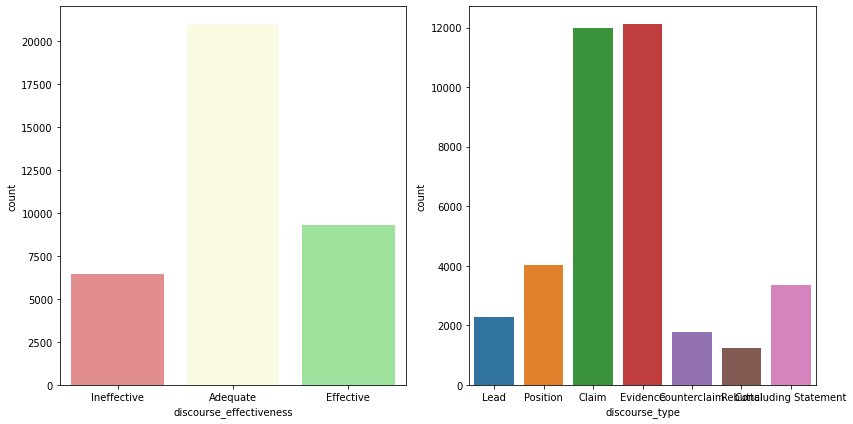

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(x="discourse_effectiveness", data=train, order = ['Ineffective', 'Adequate', 'Effective'],
              palette = ['lightcoral', 'lightyellow', 'lightgreen'], ax=ax[0])

sns.countplot(x="discourse_type", data=train,ax=ax[1])

plt.tight_layout()
plt.show()

* The target (i.e. **discourse effectiveness**) is highly unbalanced
  * There are 6462 ineffective discourses
  * There are 20977 adequate discourses
  * There are 9326 effective discourses


* The same happens for the **discourse type**
  * There are approximately 6 times more `Claims` or `Evidence` than `Counterclaims` discourses

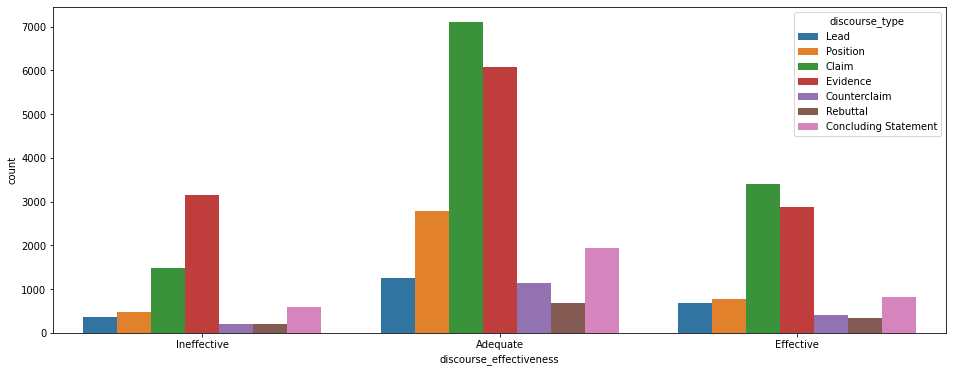

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

sns.countplot(x = 'discourse_effectiveness',
            hue = 'discourse_type', order = ['Ineffective', 'Adequate', 'Effective'] ,  data = train)
plt.show()

In [9]:
# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

all_words = train['discourse_text'].str.split(expand=True).unstack().value_counts()
data      = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet', color = all_words.values[2:100]),text='Word counts')]

layout = go.Layout(title='Top 50 (Uncleaned) Word frequencies in the training dataset [discourse_text]')
fig    = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Natural Language Processing (NLP)

In almost all Natural Language Processing tasks that you will come across (be it topic modelling, or word clustering or document-text classification, etc.), one will generally always have to undergo these few pre-processing steps to convert the input raw text into a form that is readable by your model and the machine. You certainly can't expect to feed a Random Forest model a paragraph of words and expect it to immediately predict the output. Behind the scenes, text pre-processing can be boiled down to these few simple steps:

1. **Tokenization** - Segregation of the text into its individual constitutent words.
2. **Stopwords** - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts. (as an aside also consider throwing away words that occur very infrequently).
3. **Stemming** - combine variants of words into a single parent word that still conveys the same meaning.
4. **Vectorization** - Converting text into vector format. One of the simplest is the famous `bag-of-words` approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text.

## 1. Tokenization

#### Lexicon and Corporas

* **corpus** -> A corpus can be defined as a collection of text documents. It can be thought as just a bunch of text files in a directory, often alongside many other directories of text files
* **corpora** -> body of text, ex: medical journals, presidential speeches, english language
* **lexicon** -> words and their means
* **Token** -> Each "entity" that is a part of whatever was split up based on rules. For examples, each word is a token when a sentence is "tokenized" into words. Each sentence can also be a token, if you tokenized the sentences out of a paragraph.


The concept of `tokenization` is the act of taking a sequence of characters (think of Python strings) in a given document and dicing it up into its individual constituent pieces, which are the eponymous "tokens" of this method. One could loosely think of them as singular words in a sentence. One could naively implement the "split( )" method on a string which separates it into a python list based on the identifier in the argument. It is actually not that trivial to

Here we split the first sentence of the text in the training data just on a space as follows:

In [10]:
# Storing the first text element as a string
first_text = get_essay(train['essay_id'][0], train=True)
print(first_text)
print("="*90)
print(first_text.split(" "))

Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform

I think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It's not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.

Peo

However as you can see from this first attempt at tokenization, the segregation of the sentence into its individual elements (or terms) is not entirely accurate. As an example, look at the second element of the list which contains the term **"Isaac,"**. The punctuation mark (comma) has also been included and is being treated along with the word **"Isaac"** as a term in itself. Ideally we would like the comma and the word to be in two different and separate elements of the list. 

Trying to do this with pure python list operations will be quite complex so this is where the NLTK library comes into play. There is a convenient method "word_tokenize( )" (TreebankWord tokenizer) which strips out singular words as well as punctuations into separate elements automatically as follows:

In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize

print("-------------- Sentence Tokenize --------------")
print(sent_tokenize(first_text))

print("-------------- Word Tokenize --------------")
print(word_tokenize(first_text))

-------------- Sentence Tokenize --------------
["Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it.", 'The story is about how NASA took a picture of Mars and a face was seen on the planet.', "NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.", 'On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars.', "In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet.", 'If life was on Mars, we would know by now.', 'The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure.', 'It says in paragraph 9, "It\'s not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at thi

## 2. Stopwords Removal

**`Stopwords`** are the words in any language which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For some search engines, these are some of the most common, short function words, such as the, is, at, which, and on. In this case, stop words can cause problems when searching for phrases that include them, particularly in names such as “The Who” or “Take That”.


As alluded to above stopwords are generally words that appear so commonly and at such a high frequency in the corpus that they don't actually contribute much to the learning or predictive process as a learning model would fail to distinguish it from other texts. **`Stopwords`** include terms such as "to" or "the" and therefore, it would be to our benefit to remove them during the pre-processing phase. Conveniently, NLTK comes with a predefined list of 179 english stopwords. (unhide the second cell below to see this list)

In [12]:
stopwords = nltk.corpus.stopwords.words('english')
print(len(stopwords))
print(stopwords)

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than


**To filter out stop words from our tokenized list of words, we can simply use a list comprehension as follows:**

## 3.1. Stemming

The idea of **stemming** is a sort of normalizing method. Many variations of words carry the same meaning, other than when tense is involved. The reason why we stem is to shorten the lookup, and normalize sentences.

e.g. I was taking a ride in the car. I was riding in the car.

In [13]:
ps = PorterStemmer()

ex_words = ["python","pythoner","pythoning","pythoned","pythonly"]
for s in ex_words:
    print(ps.stem(s))

python
python
python
python
pythonli


## 3.2. Lemmatization
A very similar operation to **`stemming`** is called **`lemmatizing`**. The major difference between these is, as you saw earlier, stemming can often create non-existent words, whereas lemmas are actual words.

So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma.

In [14]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize("cats"))
print(lemmatizer.lemmatize("cacti"))
print(lemmatizer.lemmatize("dogs"))
print(lemmatizer.lemmatize("corpora"))
print(lemmatizer.lemmatize("geese"))
print(lemmatizer.lemmatize("rocks"))
print(lemmatizer.lemmatize("python"))

cat
cactus
dog
corpus
goose
rock
python


In [15]:
## different approach based on noun,adjective,verb

# general
print('General_lemma:',lemmatizer.lemmatize("worst"))

# Adjective
print('Adjective_change_lemma -> worst to :',lemmatizer.lemmatize("worst", pos='a'))
print('Adjective_change_lemma -> better to:',lemmatizer.lemmatize("better",pos='a'))

# verb
print('lemma_v:',lemmatizer.lemmatize("run"))
print('lemma_verb_initiated:',lemmatizer.lemmatize("run",pos='v'))

General_lemma: worst
Adjective_change_lemma -> worst to : bad
Adjective_change_lemma -> better to: good
lemma_v: run
lemma_verb_initiated: run


## 3.3 WordNet

**WordNet** is a lexical database for the English language, which was created by Princeton, and is part of the NLTK corpus.

You can use WordNet alongside the NLTK module to find the meanings of words, synonyms, antonyms, and more

In [16]:
from nltk.corpus import wordnet

syns = wordnet.synsets("program")
print('All kind of syns:',syns)

All kind of syns: [Synset('plan.n.01'), Synset('program.n.02'), Synset('broadcast.n.02'), Synset('platform.n.02'), Synset('program.n.05'), Synset('course_of_study.n.01'), Synset('program.n.07'), Synset('program.n.08'), Synset('program.v.01'), Synset('program.v.02')]


In [17]:
## synset
print('Only first index of synset:',syns[0])
print('------------------------------------')

## lemmas
print('Apply lemmas in first index of synset:',syns[0].lemmas())
print('------------------------------------')

## just the one word
print('Name of synset:',syns[0].lemmas()[0].name())
print('------------------------------------')

## definition of particular word (eg.. plan)
print('Definition of synsets:',syns[0].definition())
print('------------------------------------')

##examples
print('Example of synsets:',syns[0].examples())
print('------------------------------------')

Only first index of synset: Synset('plan.n.01')
------------------------------------
Apply lemmas in first index of synset: [Lemma('plan.n.01.plan'), Lemma('plan.n.01.program'), Lemma('plan.n.01.programme')]
------------------------------------
Name of synset: plan
------------------------------------
Definition of synsets: a series of steps to be carried out or goals to be accomplished
------------------------------------
Example of synsets: ['they drew up a six-step plan', 'they discussed plans for a new bond issue']
------------------------------------


In [18]:
## Synonyms and Antonyms

synonyms = []
antonyms = []

for syn in wordnet.synsets("unknown"):
    for l in syn.lemmas(): #lemmas means synonyms of word
#         print("l:",l) # meaning of words in nltk library is lot
#         print('---------------------------------------------')
        synonyms.append(l.name())
        
        if l.antonyms(): #opposite of meaning
            antonyms.append(l.antonyms()[0].name())

print('Synonyms:',set(synonyms))
print('----------------------------------------------------')
print('antonyms:',set(antonyms))
print('----------------------------------------------------')

Synonyms: {'nameless', 'obscure', 'terra_incognita', 'unknown', 'stranger', 'alien', 'unidentified', 'unsung', 'unknown_quantity', 'strange', 'unknown_region', 'unnamed'}
----------------------------------------------------
antonyms: {'acquaintance', 'known'}
----------------------------------------------------


## 3.4. Similarity identification

* "Wu and Palmer method: WordNet::Similarity::wup - Perl module for computing semantic relatedness of word senses using the edge counting method of the of Wu & Palmer (1994)"

* Resnik (1999) revises the Wu & Palmer (1994) method of measuring semantic relatedness. Resnik uses use an edge distance method by taking into account the most specific node subsuming the two concepts. Here we have implemented the original Wu & Palmer method, which uses node-counting.

* If you want more details refer this one:\
https://metacpan.org/release/TPEDERSE/WordNet-Similarity-1.03/view/lib/WordNet/Similarity/wup.pm

In [19]:
word1 = wordnet.synset("computer.n.01") # n means Noun
word2 = wordnet.synset("system.n.01")

word3 = wordnet.synset("cycle.n.01") # n means Noun
word4 = wordnet.synset("bike.n.01")

word5 = wordnet.synset("ship.n.01") # n means Noun
word6 = wordnet.synset("person.n.01")

word7 = wordnet.synset("ship.n.01") # n means Noun
word8 = wordnet.synset("boat.n.01")

print('Similarity_Score of first_second words:  ', word1.wup_similarity(word2))
print('Similarity_Score of Third_fourth words:  ', word3.wup_similarity(word4))
print('Similarity_Score of fifth_sixth words:   ', word5.wup_similarity(word6))
print('Similarity_Score of seventh_eigth words: ', word7.wup_similarity(word8))

Similarity_Score of first_second words:   0.75
Similarity_Score of Third_fourth words:   0.125
Similarity_Score of fifth_sixth words:    0.4444444444444444
Similarity_Score of seventh_eigth words:  0.9090909090909091


## 4. Vectorization

### 4.1 Bag of Words

* **Frequency BOW**

In [23]:
from nltk.corpus import stopwords
ps        = PorterStemmer()
wordnet   = WordNetLemmatizer()
sentences = nltk.sent_tokenize(first_text) ## Sentence tokenization
# stopwords = stopwords.words('english')
print("Snetences: \n", sentences)

corpus = []
for i in range(len(sentences)):
    review = re.sub('[^a-zA-Z]', ' ', sentences[i])
    review = review.lower()
    review = review.split()
    review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

print("\nCorpus: \n", corpus)

Snetences: 
 ["Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it.", 'The story is about how NASA took a picture of Mars and a face was seen on the planet.', "NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.", 'On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars.', "In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet.", 'If life was on Mars, we would know by now.', 'The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure.', 'It says in paragraph 9, "It\'s not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at this point.', "In all that they're say

In [38]:
## Creating the Bag of Words model

print(np.array(corpus).shape)

cv = CountVectorizer(max_features = 1500)
X  = cv.fit_transform(corpus).toarray()
print(X.shape)

# Look at the vocabulary mapping
print("Our vocabulary: ", cv.vocabulary_)

# see the BOW rep for first 2 documents
print("BoW representation for X[0]: \n", X[0])
print("BoW representation for X[1]: \n", X[1])

(18,)
(18, 65)
Our vocabulary:  {'hi': 20, 'isaac': 21, 'going': 19, 'writing': 63, 'face': 12, 'mar': 29, 'natural': 32, 'landform': 23, 'life': 24, 'made': 27, 'story': 53, 'nasa': 31, 'took': 61, 'picture': 41, 'seen': 51, 'planet': 42, 'know': 22, 'created': 4, 'perspective': 40, 'think': 57, 'dont': 7, 'next': 34, 'paragraph': 38, 'talking': 55, 'descovered': 6, 'yet': 64, 'would': 62, 'reason': 46, 'nobody': 35, 'live': 26, 'order': 37, 'create': 3, 'figure': 13, 'say': 49, 'easy': 8, 'target': 56, 'cydonia': 5, 'saying': 50, 'point': 43, 'probably': 44, 'people': 39, 'thought': 59, 'formed': 17, 'alieans': 0, 'though': 58, 'exist': 11, 'april': 1, 'global': 18, 'surveyor': 54, 'flew': 15, 'first': 14, 'time': 60, 'michael': 30, 'malin': 28, 'orbiter': 36, 'camera': 2, 'everyone': 10, 'even': 9, 'satisfied': 48, 'since': 52, 'really': 45, 'satified': 47, 'new': 33, 'form': 16, 'like': 25}
BoW representation for X[0]: 
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 2 

* **Binary BOW**

In [40]:
## In the above code, we represented the text considering the frequency of words into account. However, sometimes, we don't care about frequency much,
## but only want to know whether a word appeared in a text or not. That is, each document is represented as a vector of 0s and 1s.
## We will use the option binary=True in CountVectorizer for this purpose.

## BoW with binary vectors
count_vect = CountVectorizer(binary=True)
temp       = count_vect.fit_transform(corpus).toarray()
print(temp.shape)

# see the BOW rep for first 2 documents
print("BoW representation for temp[0]: \n", temp[0])
print("BoW representation for temp[1]: \n", temp[1])

(18, 65)
BoW representation for temp[0]: 
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
BoW representation for temp[1]: 
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0]


### 4.2 TF-IDF

**In all the other approaches we saw so far, all the words in the text are treated equally important. There is no notion of some words in the document being more important than others. TF-IDF addresses this issue. It aims to quantify the importance of a given word relative to other words in the document and in the corpus. It was commonly used representation scheme for information retrieval systems, for extracting relevant documents from a corpus for given text query.**

TF-IDF for a word in a document is calculated by multiplying two different metrics:

* The **term frequency (TF)** of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are other ways to adjust the frequency. For example, by dividing the raw count of instances of a word by either length of the document, or by the raw frequency of the most frequent word in the document.

* The **inverse document frequency(IDF)** of the word across a set of documents. This suggests how common or rare a word is in the entire document set. The closer it is to 0, the more common is the word. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.


In [25]:
## Creating the TF-IDF model

tfidf = TfidfVectorizer()
Y     = tfidf.fit_transform(corpus).toarray()
print(Y.shape)

(18, 65)


### 4.3 One-Hot-Encoding (OHE)
* Useful for **Word Tokenization**

In [28]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

print("The data: ", corpus)
print('-------------------------------------------------')

#Label Encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(corpus)
print("Label Encoded:",integer_encoded)
print('----------------------------------------------------')

The data:  ['hi isaac going writing face mar natural landform life mar made', 'story nasa took picture mar face seen planet', 'nasa know landform created life mar natural landform', 'perspective think face natural landform dont think life mar', 'next paragraph talking think natural landform think face natural landform life mar descovered yet', 'life mar would know', 'reason think natural landform nobody live mar order create figure', 'say paragraph easy target cydonia saying easy know natural landform point', 'saying probably natural landform', 'people thought face formed alieans thought life mar', 'though say life mar exist think life mar', 'say paragraph april mar global surveyor flew cydonia first time', 'michael malin took picture mar orbiter camera face natural landform', 'everyone thought made alieans even though satisfied', 'think satisfied thought since really formed alieans', 'though people satified landform natural landform new alieans form face', 'would like know landform fo

In [34]:
# #One-Hot Encoding
# data           = [corpus.split()]
# onehot_encoder = OneHotEncoder()
# onehot_encoded = onehot_encoder.fit_transform(data).toarray()
# print("Onehot Encoded Matrix:\n", onehot_encoded)

print(label_encoder.classes_)

['everyone thought made alieans even though satisfied'
 'hi isaac going writing face mar natural landform life mar made'
 'know life mar exist' 'life mar would know'
 'michael malin took picture mar orbiter camera face natural landform'
 'nasa know landform created life mar natural landform'
 'next paragraph talking think natural landform think face natural landform life mar descovered yet'
 'people thought face formed alieans thought life mar'
 'perspective think face natural landform dont think life mar'
 'reason think natural landform nobody live mar order create figure'
 'say paragraph april mar global surveyor flew cydonia first time'
 'say paragraph easy target cydonia saying easy know natural landform point'
 'saying probably natural landform'
 'story nasa took picture mar face seen planet'
 'think satisfied thought since really formed alieans'
 'though people satified landform natural landform new alieans form face'
 'though say life mar exist think life mar'
 'would like know 

### 4.4 Bag of n-grams (BoN)
*  One hot encoding, BoW and TF-IDF treat words as independent units. There is no notion of phrases or word ordering. **Bag of Ngrams (BoN)** approach tries to remedy this. It does so by breaking text into chunks of n countigous words/tokens. This can help us capture some context, which earlier approaches could not do
* An N-gram is an N-token sequence of words: a 2-gram (more commonly called a bigram) is a two-word sequence of words like “really good”, “not good”, or “your homework”, and a 3-gram (more commonly called a trigram) is a three-word sequence of words like “not at all”, or “turn off light”.

In [41]:
# from sklearn.feature_extraction.text import CountVectorizer

## Ngram vectorization example with count vectorizer and uni, bi, trigrams
count_vect = CountVectorizer(ngram_range=(1,3))

## Build a BOW representation for the corpus
bow_rep = count_vect.fit_transform(corpus)

## Look at the vocabulary mapping
print("Our vocabulary: ", count_vect.vocabulary_)

Our vocabulary:  {'hi': 68, 'isaac': 71, 'going': 65, 'writing': 263, 'face': 42, 'mar': 118, 'natural': 144, 'landform': 82, 'life': 99, 'made': 112, 'hi isaac': 69, 'isaac going': 72, 'going writing': 66, 'writing face': 264, 'face mar': 45, 'mar natural': 128, 'natural landform': 145, 'landform life': 88, 'life mar': 100, 'mar made': 127, 'hi isaac going': 70, 'isaac going writing': 73, 'going writing face': 67, 'writing face mar': 265, 'face mar natural': 46, 'mar natural landform': 129, 'natural landform life': 147, 'landform life mar': 89, 'life mar made': 103, 'story': 219, 'nasa': 139, 'took': 256, 'picture': 182, 'seen': 214, 'planet': 186, 'story nasa': 220, 'nasa took': 142, 'took picture': 257, 'picture mar': 183, 'mar face': 123, 'face seen': 49, 'seen planet': 215, 'story nasa took': 221, 'nasa took picture': 143, 'took picture mar': 258, 'picture mar face': 184, 'mar face seen': 124, 'face seen planet': 50, 'know': 74, 'created': 15, 'nasa know': 140, 'know landform': 75

In [44]:
## see the BOW rep for first 2 documents
print("BoW representation for bow_rep[0]: \n", bow_rep[0].toarray().shape)
print("BoW representation for bow_rep[1]: \n", bow_rep[1].toarray().shape)

BoW representation for bow_rep[0]: 
 (1, 267)
BoW representation for bow_rep[1]: 
 (1, 267)


### 4.5 Word Embedding
* [Reference](https://towardsdatascience.com/word2vec-explained-49c52b4ccb71)
* [Paper](https://arxiv.org/pdf/1301.3781.pdf)

* In **BOW** and **TF-IDF**, semantic information is **NOT** stored. **TF-IDF** gives importance to unimportant words.
* There is definitely chance of over-fitting. 

* **Word embeddings** are an approach to representing text in NLP. Word embeddings is a technique where individual words are transformed into a numerical representation of the word (a vector). Where each word is mapped to one vector, this vector is then learned in a way which resembles a neural network. The vectors try to capture various characteristics of that word with regard to the overall text. These characteristics can include the semantic relationship of the word, definitions, context, etc. With these numerical representations, you can do many things like identify similarity or dissimilarity between words.
* The simplest embedding would be a **one-hot** encoding of text data where each vector would be mapped to a category.

##### 4.5 Word2Vec Architecture
* In `Word2Vec` each word in basically represented as a vector of 32 or more dimension insted of a single number.
* Here the semantic information and relation between different words is also preserved.
* There are two main architectures which yield the success of word2vec.
1. Continuous Skip-Gram Model
2. CBOW (Continuous Bag of Words) architectures.


##### 4.5.1 Continuous Skip-Gram Model
The **skip-gram model** is a simple neural network with one hidden layer trained in order to predict the probability of a given word being present when an input word is present. Intuitively, you can imagine the skip-gram model being the opposite of the CBOW model. In this architecture, it takes the current word as an input and tries to accurately predict the words before and after this current word. This model essentially tries to learn and predict the context words around the specified input word. Based on experiments assessing the accuracy of this model it was found that the prediction quality improves given a large range of word vectors, however it also increases the computational complexity.

##### 4.5.2 CBOW (Continuous Bag of Words)
This architecture is very similar to a feed forward neural network. This model architecture essentially tries to predict a target word from a list of context words. The intuition behind this model is quite simple: given a phrase `"Have a great day"` , we will choose our target word to be `“a”` and our context words to be `[“have”, “great”, “day”]`. What this model will do is take the distributed representations of the context words to try and predict the target word.

In [71]:
import time
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA

print("Length of a corpus: ", len(corpus))
sentences = [nltk.word_tokenize(sentence) for sentence in corpus]
print("Length of sentences: ", len(sentences))

for i in range(len(sentences)):
    sentences[i] = [word for word in sentences[i] if word not in stopwords.words('english')]

print("Length of sentences (after remoring stopwords): ", len(sentences))

%time
## Training the Word2Vec model
w2v_cbow     = w2v(sentences, min_count=1, sg=0) # using CBOW Architecture for trainnig
w2v_skipGram = w2v(sentences, min_count=1, sg=1) # using skipGram Architecture for training 

Length of a corpus:  18
Length of sentences:  18
Length of sentences (after remoring stopwords):  18
Wall time: 0 ns


In [72]:
%time
## Summarize vocabulary
# print(w2v_model.wv.vocab)
# print(w2v_model.wv.index_to_key)
print(w2v_cbow.wv.key_to_index)
print('\n----------------------------------------\n')
print(w2v_skipGram.wv.key_to_index)

Wall time: 0 ns
{'mar': 0, 'landform': 1, 'natural': 2, 'life': 3, 'think': 4, 'face': 5, 'know': 6, 'thought': 7, 'alieans': 8, 'say': 9, 'paragraph': 10, 'formed': 11, 'though': 12, 'people': 13, 'easy': 14, 'would': 15, 'exist': 16, 'took': 17, 'picture': 18, 'cydonia': 19, 'nasa': 20, 'made': 21, 'satisfied': 22, 'saying': 23, 'dont': 24, 'next': 25, 'talking': 26, 'descovered': 27, 'like': 28, 'perspective': 29, 'created': 30, 'planet': 31, 'seen': 32, 'story': 33, 'writing': 34, 'going': 35, 'isaac': 36, 'yet': 37, 'figure': 38, 'reason': 39, 'nobody': 40, 'new': 41, 'satified': 42, 'really': 43, 'since': 44, 'even': 45, 'everyone': 46, 'camera': 47, 'orbiter': 48, 'malin': 49, 'michael': 50, 'time': 51, 'first': 52, 'flew': 53, 'surveyor': 54, 'global': 55, 'april': 56, 'probably': 57, 'point': 58, 'target': 59, 'form': 60, 'create': 61, 'order': 62, 'live': 63, 'hi': 64}

----------------------------------------

{'mar': 0, 'landform': 1, 'natural': 2, 'life': 3, 'think': 4, 'f

In [107]:
temp = w2v_skipGram.wv.index_to_key # index_to_key, key_to_index
## list(temp.keys())[0]
for x in w2v_skipGram.wv.key_to_index:
    print(x)
    break

mar


In [73]:
## Access vector for one word
vector1 = w2v_skipGram.wv['face']
print(vector1.shape)
print('\n----------------------------------------\n')
vector2 = w2v_cbow.wv['face']
print(vector2.shape)

## Most similar words
similar1 = w2v_skipGram.wv.most_similar('picture')
print(similar1)
print('\n----------------------------------------\n')
similar2 = w2v_cbow.wv.most_similar('picture')
print(similar2)


# ## save model
# w2v_cbow.save('w2v_cbow.bin')
# w2v_skipGram.save('w2v_skipGram.bin')
# ## load model
# new_w2v_cbow = w2v.load('w2v_cbow.bin')
# new_w2v_skipGram = w2v.load('w2v_skipGram.bin')


(100,)

----------------------------------------

(100,)
[('flew', 0.2131378948688507), ('hi', 0.19289349019527435), ('probably', 0.16645999252796173), ('landform', 0.16156086325645447), ('natural', 0.1579701453447342), ('seen', 0.15731893479824066), ('time', 0.15643210709095), ('really', 0.15124183893203735), ('writing', 0.14568288624286652), ('people', 0.1445947289466858)]

----------------------------------------

[('flew', 0.21278375387191772), ('hi', 0.19244523346424103), ('probably', 0.16671882569789886), ('landform', 0.15993407368659973), ('seen', 0.1568250209093094), ('time', 0.15552903711795807), ('natural', 0.1553756296634674), ('really', 0.1505592316389084), ('writing', 0.14545303583145142), ('form', 0.14384996891021729)]


### 4.6 Doc2Vec Architecture
**Doc2Vec** is another widely used technique that creates an embedding of a document irrespective to its length. While **Word2Vec** computes a feature vector for every word in the corpus, and **Doc2Vec** computes a feature vector for every document in the corpus

In [74]:
import warnings
warnings.filterwarnings('ignore')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [75]:
tagged_data = [TaggedDocument(words=word_tokenize(word.lower()), tags=[str(i)]) for i, word in enumerate(corpus)]
tagged_data

[TaggedDocument(words=['hi', 'isaac', 'going', 'writing', 'face', 'mar', 'natural', 'landform', 'life', 'mar', 'made'], tags=['0']),
 TaggedDocument(words=['story', 'nasa', 'took', 'picture', 'mar', 'face', 'seen', 'planet'], tags=['1']),
 TaggedDocument(words=['nasa', 'know', 'landform', 'created', 'life', 'mar', 'natural', 'landform'], tags=['2']),
 TaggedDocument(words=['perspective', 'think', 'face', 'natural', 'landform', 'dont', 'think', 'life', 'mar'], tags=['3']),
 TaggedDocument(words=['next', 'paragraph', 'talking', 'think', 'natural', 'landform', 'think', 'face', 'natural', 'landform', 'life', 'mar', 'descovered', 'yet'], tags=['4']),
 TaggedDocument(words=['life', 'mar', 'would', 'know'], tags=['5']),
 TaggedDocument(words=['reason', 'think', 'natural', 'landform', 'nobody', 'live', 'mar', 'order', 'create', 'figure'], tags=['6']),
 TaggedDocument(words=['say', 'paragraph', 'easy', 'target', 'cydonia', 'saying', 'easy', 'know', 'natural', 'landform', 'point'], tags=['7']),


In [79]:
## Doc2Vec model
model_d2v = Doc2Vec(tagged_data, vector_size=20, min_count=1, epochs=2, dm=0) # see what happens if we change dim=1
print(model_d2v.infer_vector(['life','made','face'])) # feature vector of life, made & face

## top 5 most simlar words.
model_d2v.wv.most_similar("life", topn=5)

## Similarity
model_d2v.wv.n_similarity(["isaac"],["people"])

[ 0.0235203  -0.00788467  0.00272421 -0.01924115  0.01039901  0.01706493
  0.0175892   0.00540942  0.01201392 -0.01147233  0.00013491 -0.01711306
 -0.00740713  0.02000939  0.01848306  0.01352311 -0.01668338 -0.0223017
  0.00997541  0.01112321]


0.20537707

### 4.7 FastText
* As **Word2Vec** and **Doc2Vec* models rely on the `vocabulary` they had been trained on if the new text data that we want to vectorized contains words that were not previously present in the training vocabulary then these models fail to vectorized the unseen words accurately. `FastText` overcomes this problem.

* `FastText` does this by vectorizing each word as a combination of character n-grams. The keyword to remember when working with FastText is character n-grams.

*  Uses of **FastText**:
    *  Very useful for finding semantic similarities
    *  Large datasets can be trained in minutes
    *  Can be used for the purpose of text classification.

Thus the biggest advantage of using FastText over other models such as Word2Vec is that FastText can generate embeddings for sentences with words not present in the training vocabulary with the help of character n-grams whereas other models fail to do so.

[Reference](https://pythonwife.com/fasttext-in-nlp/)

In [112]:
from gensim.models import FastText
from gensim.test.utils import common_texts

# print(common_texts)

# build the FastText model
model1 = FastText(vector_size=5, window=3, min_count=1)
model1.build_vocab(common_texts)
model1.train(common_texts, total_examples=len(common_texts), epochs=10)

(36, 290)

In [114]:
print('Predict one word:',model1.wv['human'])
print('---------------------------')
print(model1.wv.most_similar(positive=['computer','interface'], negative=['human']))

Predict one word: [-0.03166138  0.0232673   0.01241681  0.00036033  0.02841444]
---------------------------
[('user', 0.7968782186508179), ('system', 0.17462214827537537), ('response', 0.10433417558670044), ('survey', 0.009605271741747856), ('trees', -0.0764053612947464), ('time', -0.13300469517707825), ('minors', -0.1392730176448822), ('eps', -0.2409365326166153), ('graph', -0.29175299406051636)]


### 4.8 [GloVe (Global Vectors)](https://www.kaggle.com/discussions/getting-started/164408)

**GloVe**: GloVe is based on matrix factorization techniques on the word-context matrix. It first constructs a large matrix of (words x context) co-occurrence information, i.e. for each “word” (the rows), you count how frequently we see this word in some “context” (the columns) in a large corpus. The number of “contexts” is of course large, since it is essentially combinatorial in size. So then we factorize this matrix to yield a lower-dimensional (word x features) matrix, where each row now yields a vector representation for each word. In general, this is done by minimizing a “reconstruction loss”. This loss tries to find the lower-dimensional representations which can explain most of the variance in the high-dimensional data.

**Why GloVe is better than Word2Vec?**

**Rather than using a window to define local context, GloVe constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus. The result is a learning model that may result in generally better word embeddings.**

* To read:

https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html



### 4.9 t-SNE (t-distributed Stochastic Neighbor Embedding) for visualize embeddings

* Visualizing data in 1 or 2 dimensions is easy - but it's not clear how to visualize embeddings which are 8-dimensional or 32-dimensional. **t-SNE** is a dimensionality reduction algorithm which is often used for visualization. It learns a mapping from a set of high-dimensional vectors, to a space with a smaller number of dimensions (usually 2), which is hopefully a good representation of the high-dimensional space.

* What makes a mapping a `"good representation"`? Put simply, **t-SNE** tries to make sure that if high-dimensional vectors  `u` and  `v`  are close together, then  `map(u)`  and  `map(v)`  are close together in the `2-d` mapping space.

* To read:
    * https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1
    * https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a

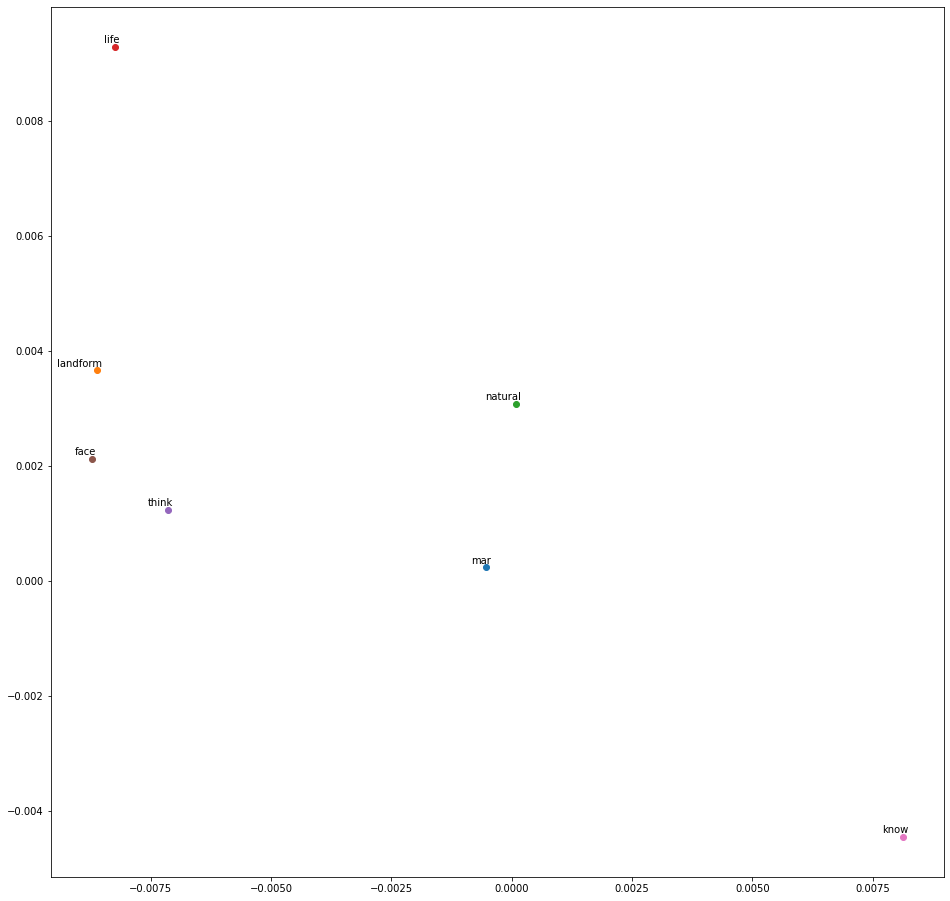

In [109]:
from sklearn.manifold import TSNE
# from gensim.models import word2vec

model = w2v(sentences, vector_size=100, min_count=5, workers=4, sg=0) # using CBOW Architecture for trainnig

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    
    tokens = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings


    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = [v[0] for v in tokens]
    y = [v[1] for v in tokens]

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model)